<span style="color: orange; font-family: Calibri Light;">
  <h1><b>TIME SERIES ANALYSIS</b></h1>
</span>
<span style = "font-family: Calibri Light">

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>I. Setting Up Environment</b></h2>
</span>

In [175]:
import pandas as pd
import numpy as np
import ast
import pickle
import csv

import datetime
import os
from glob import glob

from gensim import corpora
from gensim.models import Phrases
from gensim.models import LdaModel, CoherenceModel, LdaMulticore

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from cycler import cycler



pio.templates.default = "plotly_white"

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>II. Load & Transform Datasets</b></h2>
</span>

In [2]:
# Access dataset files
folder_path = os.path.join( "..", "bert_model_data") 
file_type = "*.csv"

# List of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../bert_model_data/bert_default_raw_text_topics_term.csv',
 '../bert_model_data/test_data_bert_raw_label.csv',
 '../bert_model_data/bert_train_lemma.csv',
 '../bert_model_data/human_and_bert_raw_labels.csv',
 '../bert_model_data/bert_default_raw_text_topics_term_labelled.csv',
 '../bert_model_data/bert_kmeans_lemma_topics_terms.csv',
 '../bert_model_data/test_data_human_label_bert_raw.csv',
 '../bert_model_data/posts_upvote_ratio.csv',
 '../bert_model_data/bert_train_no_prep.csv',
 '../bert_model_data/bert_model_1_label_train_data.csv',
 '../bert_model_data/test_data_lemma.csv']

In [3]:
def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)

In [4]:
#import cleaned data
train_data = pd.read_csv('../bert_model_data/bert_model_1_label_train_data.csv')#, converters ={'tokens':list_converter})
train_data = train_data.drop(columns = ['Unnamed: 0'])
train_data.head()

,text_type,ID,date_created,year,long_text,Topic,Name
0,comment,c5c54q4,2012-07-11 00:50:58,2012,That dessert's a bit rich for me.,-1,-1_dubai_people_just_like
1,comment,c5edn0u,2012-07-15 21:59:34,2012,"""A SILVER one?! I HATE YOU DAD!""",-1,-1_dubai_people_just_like
2,comment,c6d18gk,2012-09-25 07:57:13,2012,Yet i stared at the picture for a good 45 seco...,-1,-1_dubai_people_just_like
3,comment,c6d1cs1,2012-09-25 08:04:04,2012,seriously?,-1,-1_dubai_people_just_like
4,comment,c6d2fss,2012-09-25 09:13:23,2012,"[FYSR] = from your sister subreddit.\n\nIMO, i...",1,1_dubai_uae_arabic_people


In [5]:
train_data.drop(columns = ['year', 'Name'], inplace = True)
train_data.head()

,text_type,ID,date_created,long_text,Topic
0,comment,c5c54q4,2012-07-11 00:50:58,That dessert's a bit rich for me.,-1
1,comment,c5edn0u,2012-07-15 21:59:34,"""A SILVER one?! I HATE YOU DAD!""",-1
2,comment,c6d18gk,2012-09-25 07:57:13,Yet i stared at the picture for a good 45 seco...,-1
3,comment,c6d1cs1,2012-09-25 08:04:04,seriously?,-1
4,comment,c6d2fss,2012-09-25 09:13:23,"[FYSR] = from your sister subreddit.\n\nIMO, i...",1


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127686 entries, 0 to 127685
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text_type     127686 non-null  object
 1   ID            127686 non-null  object
 2   date_created  127686 non-null  object
 3   long_text     127683 non-null  object
 4   Topic         127686 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.9+ MB


In [7]:
test_data = pd.read_csv('../bert_model_data/human_and_bert_raw_labels.csv')
test_data.drop(columns = ['Unnamed: 0','human_topic_desc', 'human_topic_no','model_topic_desc'],inplace = True)

test_data

,text_type,ID,date_created,long_text,model_topic_no
0,submission,10embj,2012-09-24 23:02:05,Dubai cap my dad brought me! [FYSR],1
1,submission,13ch705,2023-05-09 10:04:19,Anyone here have any idea where I can park my ...,10
2,submission,13cpma4,2023-05-09 17:17:49,"UAE real estate agents and brokers, I need you...",1
3,submission,13p1nlq,2023-05-23 00:07:39,A Well Deserved Shout-out I posted in this sub...,7
4,submission,14d7052,2023-06-19 10:52:36,Furnished apartments… bedding/pots and pans Hi...,24
...,...,...,...,...,...
1195,submission,wbwik,2012-07-10 19:11:08,Only in Dubai! R8: BRAND NEW 2012 Audi R8 V8 -...,1
1196,submission,x9rwby,2022-09-09 14:27:16,Where have all the saris gone ? Was having a c...,23
1197,submission,ye87w0,2022-10-27 00:35:22,Yeah those vox movies somehow also got affecte...,9
1198,submission,z1qtro,2022-11-22 15:06:04,Unbaked croissant Any idea where you can buy u...,-1


In [13]:
ts_data.dropna?

Signature:
ts_data.dropna(
    *,
    axis: 'Axis' = 0,
    how: 'AnyAll | NoDefault' = <no_default>,
    thresh: 'int | NoDefault' = <no_default>,
    subset: 'IndexLabel' = None,
    inplace: 'bool' = False,
    ignore_index: 'bool' = False,
) -> 'DataFrame | None'
Docstring:
Remove missing values.

See the :ref:`User Guide <missing_data>` for more on which values are
considered missing, and how to work with missing data.

Parameters
----------
axis : {0 or 'index', 1 or 'columns'}, default 0
    Determine if rows or columns which contain missing values are
    removed.

    * 0, or 'index' : Drop rows which contain missing values.
    * 1, or 'columns' : Drop columns which contain missing value.

    Pass tuple or list to drop on multiple axes.
    Only a single axis is allowed.

how : {'any', 'all'}, default 'any'
    Determine if row or column is removed from DataFrame, when we have
    at least one NA or all NA.

    * 'any' : If any NA values are present, drop that row or column

In [14]:
test_data.rename(columns = {'model_topic_no': 'Topic'}, inplace = True)
ts_data = pd.concat([train_data, test_data], axis = 0, ignore_index = True)

ts_data.dropna(inplace = True, ignore_index = True)
ts_data.head()

,text_type,ID,date_created,long_text,Topic
0,comment,c5c54q4,2012-07-11 00:50:58,That dessert's a bit rich for me.,-1
1,comment,c5edn0u,2012-07-15 21:59:34,"""A SILVER one?! I HATE YOU DAD!""",-1
2,comment,c6d18gk,2012-09-25 07:57:13,Yet i stared at the picture for a good 45 seco...,-1
3,comment,c6d1cs1,2012-09-25 08:04:04,seriously?,-1
4,comment,c6d2fss,2012-09-25 09:13:23,"[FYSR] = from your sister subreddit.\n\nIMO, i...",1


In [15]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128883 entries, 0 to 128882
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text_type     128883 non-null  object
 1   ID            128883 non-null  object
 2   date_created  128883 non-null  object
 3   long_text     128883 non-null  object
 4   Topic         128883 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.9+ MB


In [17]:
#get the label pairing: topic_no --> topic_description
label_data = pd.read_csv('../bert_model_data/bert_default_raw_text_topics_term_labelled.csv', converters ={'tokens':list_converter})
label_data = label_data[['Topic','Representation', 'human_labels']]
label_data.head()

,Topic,Representation,human_labels
0,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined
1,0,"['lol', 'bot', 'true', 'comment', 'yes', 'post...",reddit_usage
2,1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region
3,2,"['thank', 'thanks', 'dm', 'instagram', 'great'...",unrelated_theme
4,3,"['racism', 'english', 'racist', 'indian', 'peo...",diversity_inclusion.race/nationality


In [18]:
# Create a mapping dictionary 
topic_mapping = label_data.set_index('Topic')[['Representation', 'human_labels']].to_dict(orient='index')

# Map the values from label_data to train_data based on the 'Topic' column
ts_data['Representation'] = ts_data['Topic'].map(lambda x: topic_mapping[x]['Representation'])
ts_data['human_labels'] = ts_data['Topic'].map(lambda x: topic_mapping[x]['human_labels'])

In [20]:
ts_data.sample(n=10)

,text_type,ID,date_created,long_text,Topic,Representation,human_labels
65249,comment,hqsewmg,2022-01-01 13:03:26,How has the weekend change been viewed among E...,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined
78549,comment,ics77t2,2022-06-18 05:13:06,And caprisone for elite class kids🤣,0,"['lol', 'bot', 'true', 'comment', 'yes', 'post...",reddit_usage
31462,comment,gatlfuo,2020-11-01 23:38:52,You just made me aware of an issue I never kne...,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined
123491,comment,jof88w7,2023-06-17 05:41:50,r/seashell,0,"['lol', 'bot', 'true', 'comment', 'yes', 'post...",reddit_usage
43220,submission,ltph5r,2021-02-27 18:41:12,"Selling an acer nitro 5 2020, 15.6”, 144hz dis...",27,"['app', 'iphone', 'apple', 'games', 'pro', 'ps...",unrelated_theme
110612,comment,jg7w20b,2023-04-14 16:11:47,spills karak everywhere,33,"['karak', 'chamak', 'chammak', 'chammaks', 'ch...",dining_services.food_teas
111250,comment,jgz70z3,2023-04-20 08:40:42,magicpashu is a CPA actually,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined
25729,comment,g1c1ckp,2020-08-13 19:06:51,"Joint Statement of the United States, the Stat...",1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region
84749,comment,ijyft6d,2022-08-12 08:48:56,Lol.....but dont hear much about it here.,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined
127364,comment,joyig29,2023-06-21 17:24:32,Thank you for sharing this! I have applied min...,18,"['visa', 'passport', 'citizenship', 'golden', ...",immigration


In [26]:
#check for duplicates
ts_data[ts_data.duplicated()]

,text_type,ID,date_created,long_text,Topic,Representation,human_labels


In [82]:
#extract submissions
submissions = ts_data[ts_data.text_type == 'submission'].copy().reset_index()

In [83]:
submissions.drop(columns = ['index'], axis = 1, inplace = True)
submissions.head()

,text_type,ID,date_created,long_text,Topic,Representation,human_labels
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,5,"['expo', 'beach', 'building', 'khalifa', 'burj...",infrastructure.landmarks
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,6,"['rain', 'summer', 'heat', 'weather', 'ac', 'h...",weather_conditions
4,submission,2aygyw,2014-07-17 18:44:26,This just hit me,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined


In [28]:
#submissions ID
sub_id = submissions['ID'].tolist()

In [85]:
upvotes = pd.read_csv('../Data/posts_upvote_ratio.csv').drop(columns = ['Unnamed: 0'])
upvotes_mapping = upvotes.set_index('ID')['upvote_ratio'].to_dict()

In [88]:
upvotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255 entries, 0 to 4254
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            4255 non-null   object 
 1   upvote_ratio  4255 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.6+ KB


In [90]:
sub_upvotes = submissions.merge(upvotes, on = 'ID', how = 'left')

sub_upvotes.head()

,text_type,ID,date_created,long_text,Topic,Representation,human_labels,upvote_ratio
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region,0.50
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,5,"['expo', 'beach', 'building', 'khalifa', 'burj...",infrastructure.landmarks,0.50
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined,0.56
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,6,"['rain', 'summer', 'heat', 'weather', 'ac', 'h...",weather_conditions,0.55
4,submission,2aygyw,2014-07-17 18:44:26,This just hit me,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined,0.50


In [93]:
sub_upvotes[sub_upvotes['upvote_ratio'].isna()]

,text_type,ID,date_created,long_text,Topic,Representation,human_labels,upvote_ratio


In [95]:
raw_submissions = pd.read_csv('../Data/full_posts.csv')
raw_submissions = raw_submissions[['ID', 'Score', 'Total Comments']].copy()

In [96]:
sub_upvotes =sub_upvotes.merge(raw_submissions, on = 'ID', how = 'left')
sub_upvotes.head()

,text_type,ID,date_created,long_text,Topic,Representation,human_labels,upvote_ratio,Score,Total Comments
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region,0.50,0,4
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,5,"['expo', 'beach', 'building', 'khalifa', 'burj...",infrastructure.landmarks,0.50,1,4
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined,0.56,1,6
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,6,"['rain', 'summer', 'heat', 'weather', 'ac', 'h...",weather_conditions,0.55,4,5
4,submission,2aygyw,2014-07-17 18:44:26,This just hit me,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined,0.50,1,5


In [173]:
sub_upvotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255 entries, 0 to 4254
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text_type       4255 non-null   object 
 1   ID              4255 non-null   object 
 2   date_created    4255 non-null   object 
 3   long_text       4255 non-null   object 
 4   Topic           4255 non-null   int64  
 5   Representation  4255 non-null   object 
 6   human_labels    4255 non-null   object 
 7   upvote_ratio    4255 non-null   float64
 8   Score           4255 non-null   int64  
 9   Total Comments  4255 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 332.5+ KB


In [177]:
sub_upvotes['date_created'] = pd.to_datetime(sub_upvotes['date_created'])
sub_upvotes['year'] = sub_upvotes['date_created'].dt.year

In [179]:
sub_upvotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255 entries, 0 to 4254
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   text_type       4255 non-null   object        
 1   ID              4255 non-null   object        
 2   date_created    4255 non-null   datetime64[ns]
 3   long_text       4255 non-null   object        
 4   Topic           4255 non-null   int64         
 5   Representation  4255 non-null   object        
 6   human_labels    4255 non-null   object        
 7   upvote_ratio    4255 non-null   float64       
 8   Score           4255 non-null   int64         
 9   Total Comments  4255 non-null   int64         
 10  year            4255 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(5)
memory usage: 349.2+ KB


In [180]:
sub_upvotes.head()

,text_type,ID,date_created,long_text,Topic,Representation,human_labels,upvote_ratio,Score,Total Comments,year
0,submission,1gupc3,2013-06-22 16:20:29,Dubai — World's Most Luxurious Places To Visit...,1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region,0.50,0,4,2013
1,submission,1sur9h,2013-12-14 11:02:08,Took this image of the Burj Khalifa from Souk ...,5,"['expo', 'beach', 'building', 'khalifa', 'burj...",infrastructure.landmarks,0.50,1,4,2013
2,submission,25d076,2014-05-12 18:29:48,Dubai Rock Fest - May 23 @ Domeland Arena / Al...,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined,0.56,1,6,2014
3,submission,273rf6,2014-06-02 15:49:56,PSA: When you see someone waving on the side o...,6,"['rain', 'summer', 'heat', 'weather', 'ac', 'h...",weather_conditions,0.55,4,5,2014
4,submission,2aygyw,2014-07-17 18:44:26,This just hit me,-1,"['dubai', 'people', 'just', 'like', 'don', 'ua...",undefined,0.50,1,5,2014


In [181]:
sub_upvotes.to_csv('../Data/sub_upvotes.csv')

<span style="color: orange; font-family: Calibri Light;">
  <h2><b>III. Time Series Analysis</b></h2>
</span>

<span style = "font-family: Calibri Light">
<p> We undertake a time-series analysis of the topics to understand the following phenomena:
    <ul>
    <li>Topic Popularity:
        Here will look at the trends of certain topics over the period, and this would be measured in a number of ways:
        <ul>
            <li>Volume of posts: topics vs. number of posts for those topics</li>
            <li>Topic Engagement: topics vs. total number of comments</li>
            <li> Sentiment: measured using the upvote ratio as an indirect measure of sentiment</li>
        </ul>
    <li> Topic Consistency:
        <ul>
            <li>Evergreen topics: topics consistently appearing every year, or at least two years</li>
            <li>flash in the pans: topics that are only popular in a particular year</li>
        </ul>
        </li>
    <li>Diversity of Discussion: how many topics discussed in a year.</li>
    <li>Peak Analysis: years where particular topics peaked, does it correlated to real-world events?</li>
    <li>Comparative analysis: how are popularity measures looking against each other? high engagement but negative sentiments? or what?</li>
        <li>Topic Relationship: do topics trend together?</li>   
</ul>
</p>
</span>

In [345]:
#exclude unwanted topics
#include entries for month and month&year
#check total number of entries per year
#exclude years with sparse data

data = pd.read_csv('../Data/sub_upvotes.csv') #load dataset

#include entries for month_year
data['month_year'] = pd.to_datetime(data['date_created']).dt.to_period('M')
data.drop(columns=['Unnamed: 0'], inplace = True)

#exclude unwanted_topics
topic_mask = data['human_labels'].isin(['undefined', 'unrelated_theme', 'reddit_usage'])
filtered_data = data[~topic_mask]

#exclude period with sparse data
year_mask = filtered_data['year']<2018
df = filtered_data[~year_mask]

df.head()

,text_type,ID,date_created,long_text,Topic,Representation,human_labels,upvote_ratio,Score,Total Comments,year,month_year
72,submission,7ntjdt,2018-01-03 13:12:09,Is your personal time better in winter than in...,6,"['rain', 'summer', 'heat', 'weather', 'ac', 'h...",weather_conditions,0.53,1,20,2018,2018-01
73,submission,7o0trg,2018-01-04 09:22:17,How much TAX would you pay back home? Let's th...,8,"['tip', 'salary', 'tipping', 'pay', 'tax', 'ti...",income/tax,0.48,0,23,2018,2018-01
74,submission,7p7057,2018-01-09 17:14:53,"Dating in dubai Hi guys, so dating for a girl ...",1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region,0.50,3,93,2018,2018-01
75,submission,7q08qq,2018-01-13 02:22:20,Any of you got a call from your ISP warning yo...,15,"['etisalat', 'whatsapp', 'vpn', 'du', 'voip', ...",infrastructure.mobile_communication_internet,0.48,3,20,2018,2018-01
76,submission,7qmbwr,2018-01-15 23:58:27,Etisalat is 🔥,15,"['etisalat', 'whatsapp', 'vpn', 'du', 'voip', ...",infrastructure.mobile_communication_internet,0.99,371,57,2018,2018-01


In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1768 entries, 72 to 4252
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   text_type       1768 non-null   object   
 1   ID              1768 non-null   object   
 2   date_created    1768 non-null   object   
 3   long_text       1768 non-null   object   
 4   Topic           1768 non-null   int64    
 5   Representation  1768 non-null   object   
 6   human_labels    1768 non-null   object   
 7   upvote_ratio    1768 non-null   float64  
 8   Score           1768 non-null   int64    
 9   Total Comments  1768 non-null   int64    
 10  year            1768 non-null   int64    
 11  month_year      1768 non-null   period[M]
dtypes: float64(1), int64(4), object(6), period[M](1)
memory usage: 179.6+ KB


In [346]:
#check total number of entries per year
entries_count = df.groupby('year').size()
print(entries_count)

year
2018     29
2019     71
2020    419
2021    422
2022    400
2023    427
dtype: int64


<span style="color: orange; font-family: Calibri Light;">
  <h3><b>a. Topic Popularity</b></h3>
</span>

<span style="color: orange; font-family: Calibri Light;">
  <h4><b>i. Volume of Posts:</b></h4>
</span>
<span style = 'font-family: Calibri Light'>
    total number of posts for top 10 topics in the period</span>

In [486]:
#filter for top 5 most popular topics through out the period
top_topics = df['human_labels'].value_counts().head(10)

top_topics

human_labels
uae_cities_region                                646
health.covid                                     164
infrastructure.landmarks                         129
pets_animal_welfare                               85
weather_conditions                                73
dining_services.restaurants/delivery_services     67
infrastructure.mobile_communication_internet      65
banking_financial_services_fraud                  49
entertainment                                     47
dining_services.food                              47
Name: count, dtype: int64

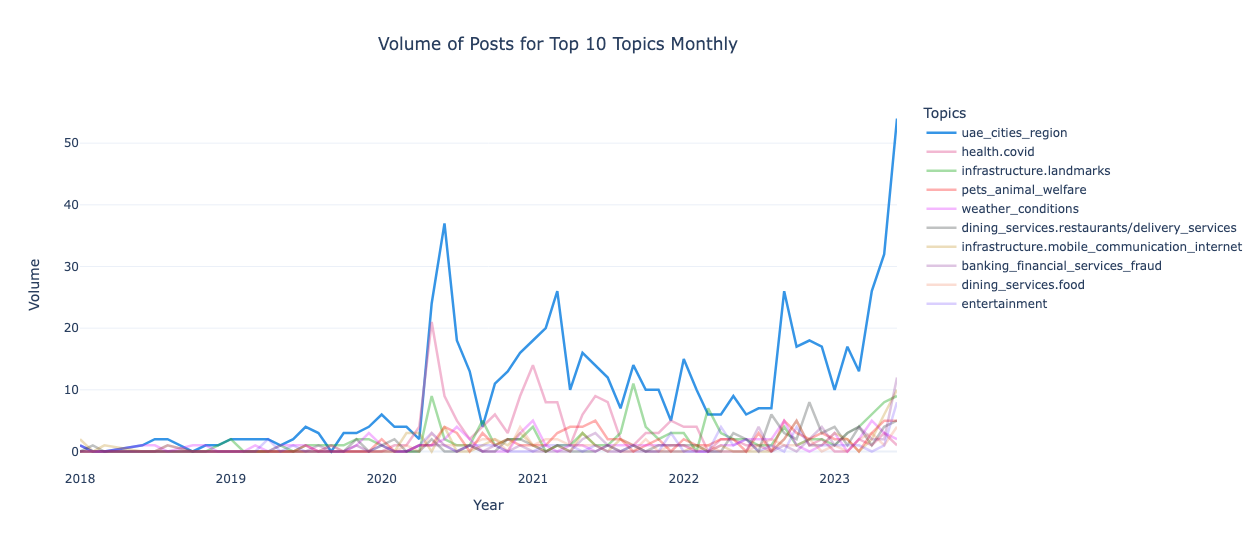

In [487]:
# Filter the data for the top 10 topics by volume
top_topics_data = df[df['human_labels'].isin(top_topics.index)]

# Group by month-year and topic to calculate the volume of posts for each topic
volume = top_topics_data.groupby(['month_year', 'human_labels']).size().unstack().fillna(0)

# Set alpha for each topic based on its volume
max_alpha = 1.0
min_alpha = 0.3
total_vol = volume.sum()
line_alpha = (total_vol/ total_vol.max() *(max_alpha - min_alpha)) + min_alpha

colors = px.colors.qualitative.Dark24

# Convert hex colors to RGB
rgb_colors = [mcolors.hex2color(color) for color in colors]

# Create the figure
fig = go.Figure()

#sort topics by volume
sorted_topics = total_vol.sort_values(ascending = False).index

# Plot line graphs with varying transparency based on volume
for idx, topic in enumerate(sorted_topics):
    r, g, b = rgb_colors[idx]
    rgba_color = f'rgba({int(r*255)},{int(g*255)},{int(b*255)},{line_alpha[topic]})'
    fig.add_trace(go.Scatter(x=volume.index.astype(str), 
                             y=volume[topic], 
                             mode='lines', 
                             name=topic, opacity = np.arange(0.6,1,.04)[::-1][idx],
                             line=dict(color=rgba_color, width=2.5)
                            ))

# Update the figure layout
fig.update_layout(
    title={"text": "Volume of Posts for Top 10 Topics Monthly", "x": 0.3},
    xaxis_title="Year",
    yaxis_title="Volume",
    legend=dict(title="Topics", x=1.03),
    xaxis_showgrid=False,
    xaxis=dict(zeroline=False),
    width=1200,
    height=550,
    autosize=False
)

# Display the figure
fig.show()

<span style="color: orange; font-family: Calibri Light;">
  <h4><b>ii. Top Engagements:</b></h4>
</span>
<span style = 'font-family: Calibri Light'>
    total number of posts for top 10 topics in the period</span>

In [490]:
#group by year and comments
top_comments = df.groupby('human_labels')['Total Comments'].sum().nlargest(10)

top_comments.sort_values()

human_labels
income/tax                                       1307
infrastructure.mobile_communication_internet     1554
urban_mobility.traffic_regulations               1605
health.covid                                     2428
weather_conditions                               2480
dining_services.food                             2592
infrastructure.landmarks                         2644
pets_animal_welfare                              3013
entertainment                                    3230
uae_cities_region                               16603
Name: Total Comments, dtype: int64

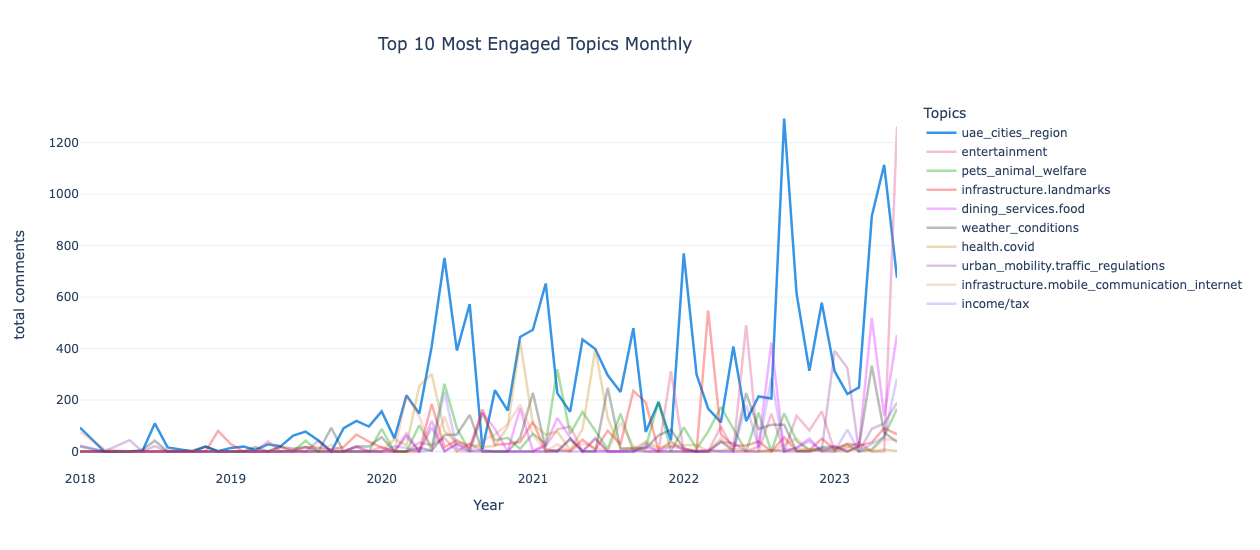

In [419]:
#data to plot
top_comments_data = df[df['human_labels'].isin(top_comments.index)]

comments = top_comments_data.groupby(['month_year','human_labels'])['Total Comments'].sum().unstack().fillna(0)


# Set alpha for each topic based on its volume
max_alpha = 1.0
min_alpha = 0.3
total_vol = comments.sum()
line_alpha = (total_vol/ total_vol.max() *(max_alpha - min_alpha)) + min_alpha

colors = px.colors.qualitative.Dark24

# Convert hex colors to RGB
rgb_colors = [mcolors.hex2color(color) for color in colors]

# Create the figure
fig = go.Figure()

#sort topics by volume
sorted_topics = total_vol.sort_values(ascending = False).index

# Plot line graphs with varying transparency based on volume
for idx, topic in enumerate(sorted_topics):
    r, g, b = rgb_colors[idx]
    rgba_color = f'rgba({int(r*255)},{int(g*255)},{int(b*255)},{line_alpha[topic]})'
    fig.add_trace(go.Scatter(x=comments.index.astype(str), 
                             y=comments[topic], 
                             mode='lines', 
                             name=topic, opacity = np.arange(0.6,1,.04)[::-1][idx],
                             line=dict(color=rgba_color, width=2.5)
                            ))

# Update the figure layout
fig.update_layout(
    title={"text": "Top 10 Most Engaged Topics Monthly", "x": 0.3},
    xaxis_title="Year",
    yaxis_title="total comments",
    legend=dict(title="Topics", x=1.03),
    xaxis_showgrid=False,
    xaxis=dict(zeroline=False),
    width=1200,
    height=550,
    autosize=False
)

# Display the figure
fig.show()

<span style="color: orange; font-family: Calibri Light;">
  <h4><b>iii. Topic Sentiments:</b></h4>
</span>
<span style = 'font-family: Calibri Light'>
    total number of posts for top 10 topics in the period</span>

In [411]:
#create general bins for upvotes - 'very positive', 'positive', 'neutral', 'negative', 'very negative'
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
upvote_data = top_comments_data.copy()
upvote_data['upvote_ratio_bin'] = pd.cut(upvote_data['upvote_ratio'], bins=bins, labels=labels, right=True)

upvote_data

,text_type,ID,date_created,long_text,Topic,Representation,human_labels,upvote_ratio,Score,Total Comments,year,month_year,upvote_ratio_bin
72,submission,7ntjdt,2018-01-03 13:12:09,Is your personal time better in winter than in...,6,"['rain', 'summer', 'heat', 'weather', 'ac', 'h...",weather_conditions,0.53,1,20,2018,2018-01,Neutral
73,submission,7o0trg,2018-01-04 09:22:17,How much TAX would you pay back home? Let's th...,8,"['tip', 'salary', 'tipping', 'pay', 'tax', 'ti...",income/tax,0.48,0,23,2018,2018-01,Neutral
74,submission,7p7057,2018-01-09 17:14:53,"Dating in dubai Hi guys, so dating for a girl ...",1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region,0.50,3,93,2018,2018-01,Neutral
75,submission,7q08qq,2018-01-13 02:22:20,Any of you got a call from your ISP warning yo...,15,"['etisalat', 'whatsapp', 'vpn', 'du', 'voip', ...",infrastructure.mobile_communication_internet,0.48,3,20,2018,2018-01,Neutral
76,submission,7qmbwr,2018-01-15 23:58:27,Etisalat is 🔥,15,"['etisalat', 'whatsapp', 'vpn', 'du', 'voip', ...",infrastructure.mobile_communication_internet,0.99,371,57,2018,2018-01,Very Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,submission,l8ttxz,2021-01-30 23:43:43,"After the passing of someone, what can I do wi...",13,"['covid', 'vaccine', 'virus', '19', 'vaccinate...",health.covid,0.75,2,2,2021,2021-01,Positive
4246,submission,neivda,2021-05-17 19:13:39,where can i buy/adopt a cat that doesn’t cost ...,11,"['cat', 'dog', 'cats', 'chicken', 'dogs', 'pet...",pets_animal_welfare,0.44,0,22,2021,2021-05,Neutral
4247,submission,rint8p,2021-12-17 22:36:41,"Senegalese food, any restaurant recommendation...",1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region,1.00,12,4,2021,2021-12,Very Positive
4248,submission,rxnqln,2022-01-07 00:11:25,Himalayan Salt Lamp....? Where in UAE can I ge...,1,"['dubai', 'uae', 'arabic', 'people', 'sharjah'...",uae_cities_region,0.67,1,7,2022,2022-01,Positive


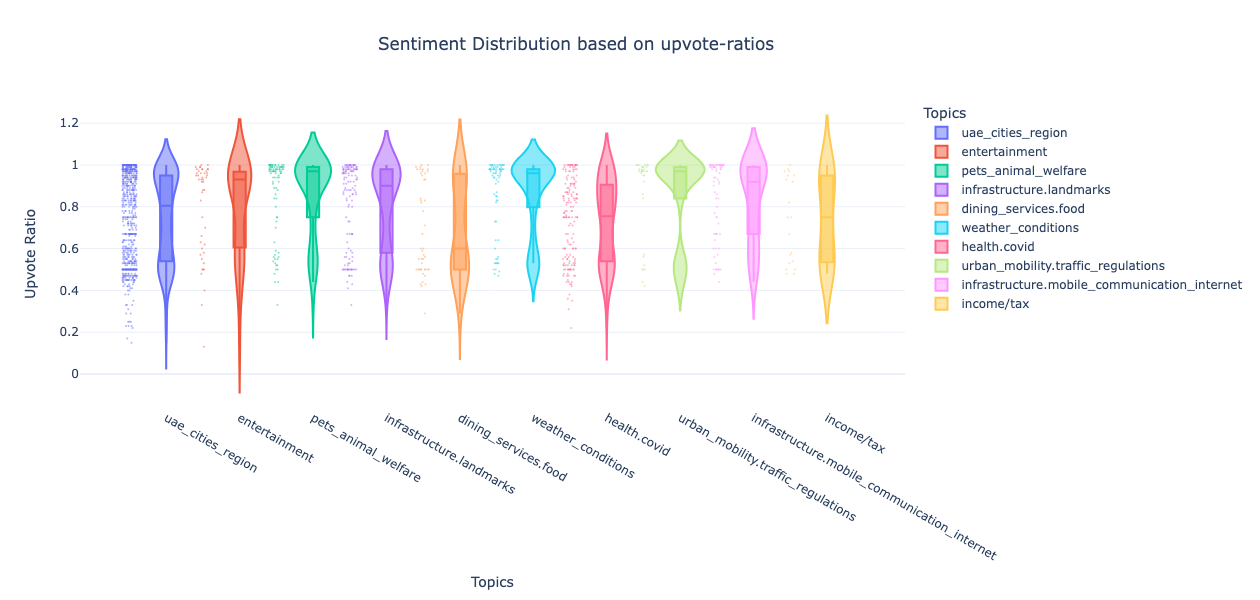

In [435]:
# Create a violin plot with Plotly
fig = px.violin(upvote_data, y="upvote_ratio", x="human_labels", color = "human_labels",
                box=True, points="all", title="Sentiment Distribution for Top 10 Topics",
                labels={"human_labels": "Topics", "upvote_ratio": "Upvote Ratio"}, height = 600,
                category_orders={"human_labels": top_comments.index.tolist()})

# Customize the appearance
fig.update_traces(marker=dict(size=2, opacity=0.5), selector=dict(type='violin'))
fig.update_layout(violingap=0.05, violingroupgap=0.3, 
                  violinmode="overlay", title={"text": "Sentiment Distribution based on upvote-ratios", "x": 0.3} )

# Show the plot
fig.show()

In [466]:
# Extract month from month_year for grouping
monthly_diversity['month'] = monthly_diversity['month_year'].dt.month

# Pivot the monthly_diversity DataFrame to have years as columns and month as rows
pivot_diversity_month = monthly_diversity.pivot(index='month', columns='year', values='human_labels').fillna(0)

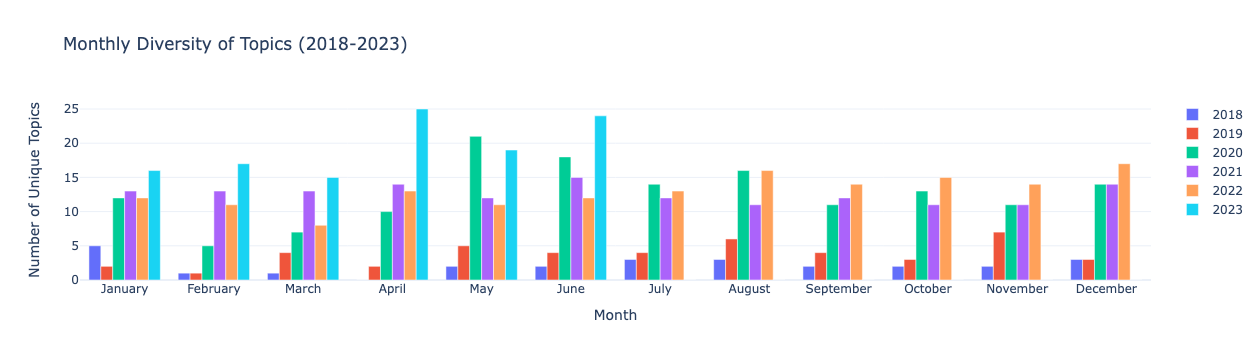

In [469]:
# Generate the grouped bar plot
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig = go.Figure()

for idx, year in enumerate(range(2018, 2024)):
    fig.add_trace(go.Bar(x=months, 
                         y=pivot_diversity_month[year], 
                         name=str(year), 
                         marker_color=colors[idx]))

# Update layout
fig.update_layout(
    title="Monthly Diversity of Topics (2018-2023)",
    xaxis_title="Month",
    yaxis_title="Number of Unique Topics",
    barmode='group'
)

fig.show()

In [471]:
# Window size for rolling mean and standard deviation
window_size = 3

# Calculate rolling mean and standard deviation for each topic
rolling_means = top_topics_data.groupby(['month_year', 'human_labels']).size().unstack().fillna(0).rolling(window=window_size).mean()
rolling_stds = top_topics_data.groupby(['month_year', 'human_labels']).size().unstack().fillna(0).rolling(window=window_size).std()

# Identify peaks where volume of posts is greater than rolling mean plus 1 standard deviation
peaks = top_topics_data.groupby(['month_year', 'human_labels']).size().unstack().fillna(0) > (rolling_means + rolling_stds)

peaks.head()

human_labels,banking_financial_services_fraud,dining_services.food,dining_services.restaurants/delivery_services,entertainment,health.covid,infrastructure.landmarks,infrastructure.mobile_communication_internet,pets_animal_welfare,uae_cities_region,weather_conditions
month_year,,,,,,,,,,
2018-01,False,False,False,False,False,False,False,False,False,False
2018-02,False,False,False,False,False,False,False,False,False,False
2018-03,False,False,False,False,False,False,False,False,False,False
2018-06,False,False,False,False,False,False,False,False,True,True
2018-07,False,False,False,False,False,False,False,False,False,False


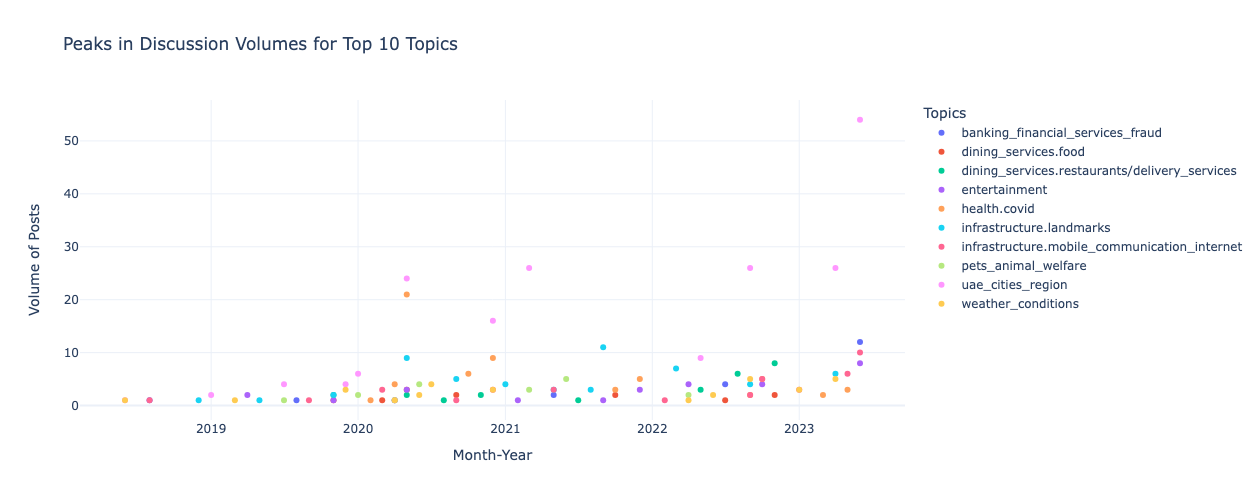

In [476]:
#peaks
import plotly.graph_objects as go

# Create a new Figure
fig = go.Figure()

# Loop through each topic and add scatter plot for the peaks
for topic in peaks.columns:
    fig.add_trace(go.Scatter(
        x=peaks.index.astype(str)[peaks[topic]],  # Only select months with peaks
        y=[top_topics_data.groupby(['month_year', 'human_labels']).size().unstack()[topic][month] for month in peaks.index if peaks[topic][month]],
        mode='markers',
        name=topic
    ))

# Update layout for clarity
fig.update_layout(
    title="Peaks in Discussion Volumes for Top 10 Topics",
    xaxis_title="Month-Year",
    yaxis_title="Volume of Posts",
    height = 500,
    legend_title="Topics"
)

# Show the figure
fig.show()


## **LOAD MODEL AND CORPUS**

In [31]:
model = LdaModel.load("../topic_modelling/lda_model_1")

In [35]:
#convert df['tokens'] to list of strings for bag-of-words model
docs = data['tokens'].tolist()

#from gensim bag of words documentation page

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5000
Number of documents: 65987


In [36]:
model.print_topics()

[(0,
  '0.026*"police" + 0.015*"building" + 0.014*"family" + 0.012*"parent" + 0.012*"wife" + 0.011*"area" + 0.011*"parking" + 0.011*"metro" + 0.011*"child" + 0.010*"station"'),
 (1,
  '0.039*"visa" + 0.021*"card" + 0.014*"apply" + 0.013*"bank" + 0.013*"visit" + 0.013*"travel" + 0.012*"website" + 0.010*"book" + 0.010*"plan" + 0.010*"cancel"'),
 (2,
  '0.017*"price" + 0.017*"buy" + 0.016*"salary" + 0.015*"cost" + 0.014*"rent" + 0.012*"property" + 0.012*"market" + 0.010*"aed" + 0.010*"sell" + 0.009*"offer"'),
 (3,
  '0.020*"law" + 0.018*"government" + 0.016*"local" + 0.014*"muslim" + 0.011*"culture" + 0.011*"arab" + 0.010*"rule" + 0.009*"community" + 0.009*"expat" + 0.008*"citizenship"'),
 (4,
  '0.036*"covid" + 0.030*"test" + 0.024*"fine" + 0.013*"vaccine" + 0.012*"worker" + 0.012*"stop" + 0.012*"mask" + 0.010*"medical" + 0.010*"hospital" + 0.010*"pandemic"'),
 (5,
  '0.036*"food" + 0.027*"order" + 0.024*"buy" + 0.022*"restaurant" + 0.022*"tip" + 0.022*"service" + 0.021*"delivery" + 0.01

In [67]:
#topic label

topic_label ={
    0: "infrastructure",
    1: "travel",
    2: "accomodation and rental",
    3: "locals and culture",
    4: "covid",
    5: "food and dining",
    6: "driving and road safety",
    7: "weather and outdoors",
    8: "education and educational facilities",
    9: "entertainment and recreation"
    
}

In [68]:
#dataset of topcis and topic representation
num_topics = model.num_topics

topics_words = []

for topic in range(num_topics):
    topic_words = model.show_topic(topic, topn = 10)
    words = [word[0] for word in topic_words]
    topics_words.append({"topic": topic, "words": words, "label":topic_label[topic]})
    

#create a dataframe
topics_df = pd.DataFrame(topics_words)

topics_df
    


,topic,words,label
0,0,"[police, building, family, parent, wife, area,...",infrastructure
1,1,"[visa, card, apply, bank, visit, travel, websi...",travel
2,2,"[price, buy, salary, cost, rent, property, mar...",accomodation and rental
3,3,"[law, government, local, muslim, culture, arab...",locals and culture
4,4,"[covid, test, fine, vaccine, worker, stop, mas...",covid
5,5,"[food, order, buy, restaurant, tip, service, d...",food and dining
6,6,"[drive, road, lane, fast, speed, pass, light, ...",driving and road safety
7,7,"[water, beach, movie, summer, cat, ban, hot, t...",weather and outdoors
8,8,"[indian, arabic, middle, passport, school, uni...",education and educational facilities
9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation


In [45]:
#include column for most probable topic for each entry

top_topic_per_document = []

for doc in corpus:
    topics = model.get_document_topics(doc)
    top_topic = sorted(topics, key=lambda x: x[1], reverse = True)[0][0]
    top_topic_per_document.append(top_topic)
    
#add column to data dataframe for the selected topic
data['top_topic'] = top_topic_per_document    

In [74]:
#merge topic label data dataframes

full_df = pd.merge(data, topics_df, left_on = "top_topic", right_on = 'topic')
full_df

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count,top_topic,topic,words,label
0,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel past,"[single, travel, past]",3,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
1,comment,gtgfl4c,2021-04-05 18:21:42,2021,Is reel cinema and roxy part of emaar?,reel cinema roxy emaar,"[reel, cinema, roxy, emaar]",4,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
2,comment,gtfs2hs,2021-04-05 14:05:30,2021,Really? In springs souk? I never noticed it be...,souk cinema covid,"[souk, cinema, covid]",3,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
3,comment,gtghuux,2021-04-05 18:40:31,2021,"Reel cinema is, dont know of roxy",reel cinema roxy,"[reel, cinema, roxy]",3,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
4,comment,gth2mea,2021-04-05 21:18:14,2021,It’s a simple “joke” but I couldn’t resist. In...,resist mildly amusing misspell language offens...,"[resist, mildly, amusing, misspell, language, ...",9,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
...,...,...,...,...,...,...,...,...,...,...,...,...
65982,submission,14d6x2j,2023-06-19 10:47:32,2023,Eid Al Adha 2023 holidays announced for privat...,eid holiday announce private sector,"[eid, holiday, announce, private, sector, priv...",5,3,3,"[law, government, local, muslim, culture, arab...",locals and culture
65983,submission,14dk6mw,2023-06-19 21:02:21,2023,newspaper/website recommendations for local ec...,newspaper website local economic spam trust ec...,"[newspaper, website, local, economic, spam, tr...",9,3,3,"[law, government, local, muslim, culture, arab...",locals and culture
65984,submission,14dfnr1,2023-06-19 18:07:20,2023,Custom patches Newbie here. do you guys know ...,custom patch newbie patch custom logo,"[custom, patch, newbie, patch, custom, logo]",6,3,3,"[law, government, local, muslim, culture, arab...",locals and culture
65985,submission,14csv18,2023-06-18 23:31:06,2023,BEIN Channels no longer available on e&amp; (e...,channel amp etisalat temporary permanent disco...,"[channel, amp, etisalat, temporary, permanent,...",8,3,3,"[law, government, local, muslim, culture, arab...",locals and culture


In [78]:
#topics assigned to posts
sub_topics = full_df[full_df.text_type == 'submission']
sub_topics

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count,top_topic,topic,words,label
5242,submission,z7hou7,2022-11-29 07:12:18,2022,Shout out to the lady who taught krisfade a le...,shout lady teach lesson lady confront overly p...,"[shout, lady, teach, lesson, lady, confront, o...",22,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
5243,submission,jtxdl9,2020-11-14 10:33:18,2020,"In the midst of a pandemic, I have finally com...",midst pandemic complete collection coin circul...,"[midst, pandemic, complete, collection, coin, ...",6,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
5244,submission,k6iba8,2020-12-04 14:13:50,2020,Juma prayer ft. Social distancing,prayer social distancing,"[prayer, social, distancing, social_distancing]",3,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
5245,submission,fr0bwu,2020-03-29 09:06:05,2020,Social distancing and tailgaters...,social distancing tailgater,"[social, distancing, tailgater, social_distanc...",3,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
5246,submission,nqr3lx,2021-06-02 21:22:42,2021,Saw this outside my office today (Deira). You’...,outside office deira,"[outside, office, deira]",3,9,9,"[night, mall, walk, hotel, room, area, drink, ...",entertainment and recreation
...,...,...,...,...,...,...,...,...,...,...,...,...
65982,submission,14d6x2j,2023-06-19 10:47:32,2023,Eid Al Adha 2023 holidays announced for privat...,eid holiday announce private sector,"[eid, holiday, announce, private, sector, priv...",5,3,3,"[law, government, local, muslim, culture, arab...",locals and culture
65983,submission,14dk6mw,2023-06-19 21:02:21,2023,newspaper/website recommendations for local ec...,newspaper website local economic spam trust ec...,"[newspaper, website, local, economic, spam, tr...",9,3,3,"[law, government, local, muslim, culture, arab...",locals and culture
65984,submission,14dfnr1,2023-06-19 18:07:20,2023,Custom patches Newbie here. do you guys know ...,custom patch newbie patch custom logo,"[custom, patch, newbie, patch, custom, logo]",6,3,3,"[law, government, local, muslim, culture, arab...",locals and culture
65985,submission,14csv18,2023-06-18 23:31:06,2023,BEIN Channels no longer available on e&amp; (e...,channel amp etisalat temporary permanent disco...,"[channel, amp, etisalat, temporary, permanent,...",8,3,3,"[law, government, local, muslim, culture, arab...",locals and culture


In [81]:
filename = '../Data/subs_topics.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    sub_topics.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')

file saved
